<a href="https://colab.research.google.com/github/IvanDePivan/2AMM30-groep-2-component-1/blob/main/HF_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RE using Hugging face

Importing and installing the required packages

In [1]:
import pandas as pd
import json
import numpy as np
import spacy
from spacy.training.example import Example #holds information for one training instance
import random
from tqdm import tqdm
from spacy.scorer import Scorer
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
from torch import nn
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoConfig
import datetime
from matplotlib.colors import LogNorm, Normalize
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

Import the data from label studio

In [2]:
# Authenticate
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

# Get email of current Colab user
import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
email = gcloud_tokeninfo['email']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define filepath
if email == 'tamaraexterkate93@gmail.com':
  filename = "/content/drive/MyDrive/TUe/TM/Exports/export_component_1.json"
elif email == 'n.v.diermen@student.tue.nl':
  filename = "/content/drive/MyDrive/Text Mining/export_component_1.json"

In [4]:
# Obtain data from Label Studio and put in right format
DATA = []

# read json file
with open(filename, 'rb') as fp:
  training_data = json.load(fp)

  # get text, labels, relations, benchmark for each article
  for article in training_data:
    entities = []
    id_entities = []
    relations = []
    original_text = article.get('data').get('text')
    if len(article.get('annotations')) == 5: # N=5
      benchmark = True
    else:
      benchmark = False
    for annotation in article.get('annotations'):
      if annotation.get('ground_truth') == True: # only include ground truth
        for ind, label in enumerate(annotation.get('result')):
          if label.get('type') == 'labels':
            start = label.get('value').get('start')
            end = label.get('value').get('end')
            id = label.get('id')
            text = label.get('value').get('text')
            label = label.get('value').get('labels')[0] # note: cannot deal with multiple labels
            id_entities.append((start, end, label, id, text))
            entities.append((start, end, label))
          elif label.get('type') == 'relation':
            from_id = label.get('from_id')
            to_id = label.get('to_id')
            relation = label.get('labels')[0] # note: cannot deal with multiple relations
            if relation != "same_as":
              relations.append((from_id, to_id, relation))
          else:
            print("found unknown label type (no label or relation)")

    # append article to training data as dictionary
    DATA.append({
    'text': original_text,
    'entities': entities,
    'id_entities': id_entities,
    'relations': relations,
    'benchmark': benchmark
    })

In [5]:
# Remove entities with smallest span in case of overlapping entities
def remove_overlap(entities):
  """ Returns the entities with the shortest ones removed in case of overlap """
  # Initialize a list to store the final non-overlapping entities
  final_entities = []

  # Sort the entities by their start position in ascending order
  entities.sort(key=lambda entity: entity[0])

  # Iterate through the sorted entities
  for entity in entities:
      overlaps = False
      for existing_entity in final_entities:
          # Check for overlapping entities
          if (entity[0] >= existing_entity[0] and entity[0] < existing_entity[1]) or \
            (entity[1] > existing_entity[0] and entity[1] <= existing_entity[1]):
              overlaps = True
              break
      if not overlaps:
          final_entities.append(entity)

  return final_entities

for article in DATA:
  article['entities'] = remove_overlap(article['entities'])

In [6]:
# split data in train, validate and test set

def train_test_split(data, val_size):
  """Splits data in a train, validation and test set """

  print(f'Total articles: {len(data)}')
  benchmark = [article for article in data if article['benchmark']]
  data = [article for article in data if not article['benchmark']]
  train_end = int(len(data)*(1-val_size))
  train = data[0:train_end]
  val = data[train_end:len(data)]

  print(f'Size train: {len(train)}')
  print(f'Size val: {len(val)}')
  print(f'Size test: {len(benchmark)}')

  return train, val, benchmark

train, val, test =  train_test_split(DATA, val_size=0.25)

Total articles: 137
Size train: 72
Size val: 25
Size test: 40


Create and prune input for RE

In [7]:
# add markers around entities and add the markers to the vocabulary

def insert_markers(text, pair):
  """ Inserts the right marker tokens around the entities provided in the pair """
  label_to_marker = {
      'Winner': '[WINR]',
      'Date': '[DATE]',
      'Prizetype': '[PRZT]',
      'Reason': '[REAS]',
      'Nationality': '[NTLY]'
  }

  start_to_add = 0
  end_to_add = 7
  for ent in pair:
    start = ent[0]
    end = ent[1]
    label = ent[2]
    start += start_to_add
    end += end_to_add
    text = text[:start] + label_to_marker[label] + ' ' + text[start:]
    text = text[:end] +' '+ label_to_marker[label] + text[end:]
    start_to_add += 7*2
    end_to_add += 7*2

  return text

special_tokens = ["[WINR]", "[DATE]", "[REAS]", "[NTLY]", "[PRZT]"]

In [8]:
# check if and which relation exists between two entities

def get_relation(pair, relations):
  """ Returns the relation between two entities and no_relation if there is none """
  if pair[0][3] and pair[1][3]: # check if entities of pair exist in annotations
    # see if and what relation there is between the entities of the pair
    for relation in relations:
      if (relation[0] == pair[0][3] and relation[1] == pair[1][3]) or (relation[1] == pair[0][3] and relation[0] == pair[1][3]):
          return relation[2]
  return 'no_relation'

In [9]:
# get maximum relation distances for pruning

def get_distances(DATA):
  """ Returns maximum distances between entities per relation type """
  all_distances = {}
  for data in DATA:
    for relation in data['relations']:
      rel_from_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[0]]
      rel_to_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[1]]
      distance = abs(rel_from_begin[0] - rel_to_begin[0])

      if all_distances.get(relation[2]) == None:
        all_distances[relation[2]] = distance
      else:
        all_distances[relation[2]] = max(all_distances[relation[2]], distance)

  return all_distances

max_span_per_relation = get_distances(train)

# obtain the maximum relation span between winner and other entity
max_span = {
'Date': max(max_span_per_relation['born_on'],max_span_per_relation['died_on'],max_span_per_relation['received_nobelprize_in']),
'Prizetype': max_span_per_relation['has_won'],
'Reason': max_span_per_relation['received_nobelprize_for'],
'Nationality': max_span_per_relation['has_nationality']}

In [10]:
def mark_data(data, NER_output=True, prune = None):
  """
  Creates the (pruned) input for performing Relation Extraction, which exists of
  the text with two entities highlighted and their corresponding relation or
  no_relation if there is none.

  Input:
  data: the data which has to be transformed to RE input
  NER_output: a dummy variable indicating wether we are working with the output
    of Label Studio (False) or the output of the NER model (True)
  prune = the factor with which the maximum distance is multiplied for pruning
    and None if no pruning is desired.

  Output:
  data_output: the text instances with their entities highlighted by marker tokens
  relations_output: the relation between these entities, with no_relation if
    there is none

  """

  # init data output and relations list
  data_output = []
  relations_output = []

  # iterate over each article in data
  for article in data:

    # get original text and convert to doc
    text = article['text']

    # get seperate list of winner entities and other entities in fixed format (start,end,label,id)
    if NER_output:
      # create doc
      doc = best_nlp(text)

      winners = []
      others = []
      for ent in doc.ents:
        # check to what entity in the annotations the NER entity refers to
        for original_ent in article['id_entities']:
          ent_id = None # refer to None if entity is not in annotations
          # otherwise overwrite with id of entity in annotations
          if ent.start_char == original_ent[0] and ent.end_char == original_ent[1]:
            ent_id = original_ent[3]
            break
        if ent.label_=='Winner':
          winners.append((ent.start_char, ent.end_char, ent.label_, ent_id))
        else:
          others.append((ent.start_char, ent.end_char, ent.label_, ent_id))

    else:
      ents = article['id_entities']
      winners = [ent for ent in ents if ent[2] =='Winner']
      others = [ent for ent in ents if ent[2] !='Winner']

    # make pairs for possible relations (winner + other)
    pairs = []

    for winner in winners:
      for other in others:
        # check if entities are within the maximum relation span of each other
        if prune == None or abs(winner[0]-other[0]) <= prune*max_span[other[2]]:
          if winner[0] < other[0]:
            pairs.append((winner,other))
          else:
            pairs.append((other,winner))

    # create new text with markers for each possible relation with winner
    new_texts = [insert_markers(text, pair) for pair in pairs]
    relations_output.extend([get_relation(pair, article['relations']) for pair in pairs])
    data_output.extend(new_texts)

  return np.array(data_output), np.array(relations_output)

In [11]:
def check_contains_relation(tokens, marker_tokens):
  """Return True if piece of text (tokens) contains a possible relation (= 4 marker tokens)."""

  marker_token_counts = {marker_token: tokens.count(marker_token) for marker_token in marker_tokens}
  nr_marker_tokens = sum(marker_token_counts.values())
  return nr_marker_tokens == 4

def split_paragraphs(X_data, y_data):
  """Split the text into seperate paragraphs"""
  # init
  X_result = []
  y_result = []

  for x, y in zip(X_data, y_data):
    for paragraph in x.split('\n'):
      contains_markers = check_contains_relation(paragraph, special_tokens)
      if contains_markers:
        X_result.append(paragraph)
        y_result.append(y)

  return np.array(X_result), np.array(y_result)

In [12]:
# put the data in the right format and prune pairs if they are further than 1.2 times the maximum observed distance
X_train, y_train = mark_data(train, NER_output=False, prune =1.2)
X_val, y_val = mark_data(val, NER_output=False, prune =1.2)
X_test, y_test = mark_data(test, NER_output=False, prune =1.2)

# split paragraphs to avoid exceeding the maximum sequence lenght by BERT (512)
X_train, y_train = split_paragraphs(X_train, y_train)
X_val, y_val = split_paragraphs(X_val, y_val)
X_test, y_test = split_paragraphs(X_test, y_test)


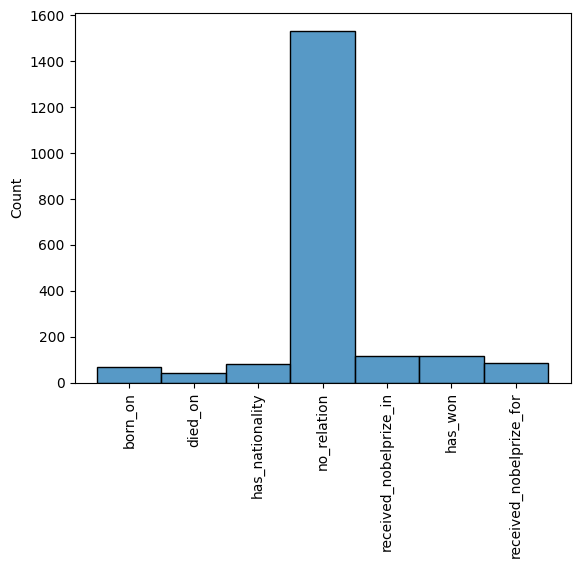

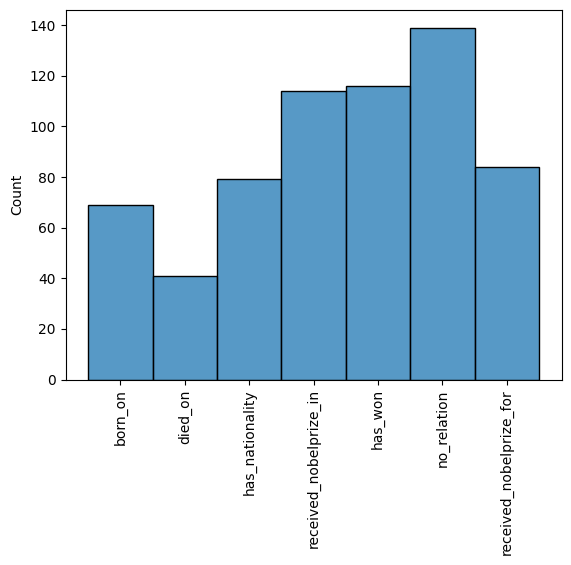

In [13]:
# vizualize the class imbalance for no relation
sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()

def downsample(X,y,sample_factor = 1):
  """ Downsamples the no_relation class up to sample_factor times the second highest class samples """
  # get second highest category
  label_counts = Counter(y)
  relation_counts = label_counts.copy()
  relation_counts.pop('no_relation')
  n_samples = round(sample_factor * max(relation_counts.values())) # allow slight class imbalance for no_relation

  # if no_relation imbalanced, randomly downsample these relations
  if label_counts['no_relation'] - n_samples > 0:
    desample_mask = y != 'no_relation'
    ind_no_relation = np.where(y == 'no_relation')[0]
    include_no_relations = (np.random.choice(ind_no_relation,n_samples, replace = False))
    desample_mask[include_no_relations] = 1
  y = y[desample_mask]
  X = X[desample_mask]

  return X,y

# randomly downsample no_relation in train
X_train, y_train = downsample(X_train,y_train, sample_factor =1.2)

# vizualize new class distribution
sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()


In [14]:
# assign class labels to each relation
id2label = {0: "no_relation", 1: "received_nobelprize_for", 2: "has_won", 3: "received_nobelprize_in", 4: "born_on", 5: "died_on", 6: "has_nationality"}
label2id = {"no_relation": 0, "received_nobelprize_for": 1, "has_won": 2, "received_nobelprize_in": 3, "born_on": 4, "died_on": 5, "has_nationality": 6}

y_train = [label2id[label] for label in y_train]
y_val = [label2id[label] for label in y_val]
y_test = [label2id[label] for label in y_test]

Set up our customized distilbert-base-uncased model

In [15]:
# load distil-bert-uncased
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# add our markers as tokens to vocabulary
num_added_toks = tokenizer.add_tokens(special_tokens)
print('We have added', num_added_toks, 'tokens')

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

We have added 5 tokens


In [16]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, input_data, labels, tokenizer, max_length):
        self.input_data = input_data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        text = self.input_data[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define hyperparameters
max_seq_length = 128  # You can adjust this as needed
batch_size = 2  # You can adjust this as needed

# Create custom datasets
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_seq_length)
val_dataset = CustomDataset(X_val, y_val, tokenizer, max_seq_length)
test_dataset = CustomDataset(X_test, y_test, tokenizer, max_seq_length)


In [17]:
# set evaluation metric

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
# define custom model
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=7, id2label=id2label, label2id=label2id
)

model.resize_token_embeddings(len(tokenizer))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30527, 768)

Train and save model

In [19]:
# define trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0,1.0,1.0,1.0,1.0,2.0,1.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# train
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.527010,0.715655
2,No log,1.065649,0.664537
3,No log,0.838185,0.674121
4,No log,0.599749,0.798722
5,No log,0.835557,0.722045
6,No log,0.640126,0.789137
7,No log,0.788705,0.744409
8,No log,0.753069,0.773163
9,No log,0.706817,0.805112
10,No log,0.659758,0.808307


TrainOutput(global_step=820, training_loss=0.3106040233519019, metrics={'train_runtime': 283.6674, 'train_samples_per_second': 45.264, 'train_steps_per_second': 2.891, 'total_flos': 425258265692160.0, 'train_loss': 0.3106040233519019, 'epoch': 20.0})

In [20]:
# save best model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define filepath to save best model
if email == 'tamaraexterkate93@gmail.com':
  filepath = f"/content/drive/MyDrive/TUe/TM/saved_models/{timestamp}"
elif email == 'n.v.diermen@student.tue.nl':
  filepath = f"/content/drive/MyDrive/Text Mining/saved_models/{timestamp}"

best_model_path = trainer.state.best_model_checkpoint
best_tokenizer = AutoTokenizer.from_pretrained(best_model_path)
best_config = AutoConfig.from_pretrained(best_model_path)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path, config=best_config).to(device)
best_model.save_pretrained(filepath)
print(f'Best model saved at {filepath}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Best model saved at /content/drive/MyDrive/Text Mining/saved_models/20231109-085223


Apply model on test data

In [21]:
# get predictions and true relations

test_output = trainer.predict(test_dataset)
y_true = test_output[1]
y_pred = np.argmax(test_output[0], axis=1)

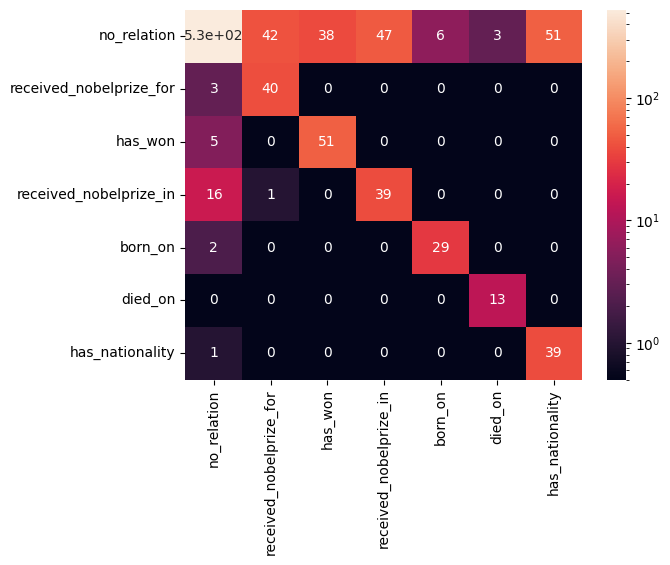

In [22]:
# plot confusion matrix in log scale

cm = confusion_matrix(y_true,y_pred)
cm_color = np.where(cm==0,0.5,cm)
sns.heatmap(cm_color, annot=cm, xticklabels = id2label.values(), yticklabels = id2label.values(), norm=LogNorm(vmin=0.5))

plt.show()